In [1]:
from sklearn.metrics import recall_score, accuracy_score, roc_curve, auc, f1_score, fbeta_score
from sklearn.preprocessing import OneHotEncoder
from scipy import interp
from itertools import cycle

import spacy
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:

nlp = spacy.load("../models/model1")
textcat = nlp.get_pipe('textcat')

def predict(sentence = "What does life even mean ?"):
    docs = nlp.tokenizer(sentence)
    # Use textcat to get the scores for each doc
    scores, _ = textcat.predict([docs])
    label = scores.argmax()
    return scores, textcat.labels[label]

In [3]:
# Reading training data
with open('../data/processed/testing_set.json') as f:
  testingData = json.load(f)

# Creating a dataframe with the training data
d_testingData = pd.DataFrame(testingData)

# Sentence example
print(testingData[0], predict(testingData[0]["sentence"]))
y_true = np.array([expected['intent'] for expected in testingData])
y_pred = np.array([predict(expected['sentence'])[1] for expected in testingData])
y_score = np.array([predict(expected['sentence'])[0][0] for expected in testingData])

print(y_true[1], y_pred[1], y_score[1])

{'intent': 'irrelevant', 'sentence': 'Tu sais où je peux acheter un bazooka ?'} (array([[2.0215701e-07, 2.6152105e-09, 1.5415856e-11, 3.3006120e-07,
        1.0594811e-07, 1.3133098e-05, 1.4320197e-09, 9.9998629e-01]],
      dtype=float32), 'purchase')
irrelevant find-hotel [4.0204725e-08 1.4341611e-09 9.9981922e-01 1.5436640e-11 2.3821159e-11
 1.2798970e-06 4.7362061e-09 1.7956574e-04]


In [4]:
# recall
print("micro : \t", recall_score(y_true, y_pred, average = "micro"))
print("weighted : \t", recall_score(y_true, y_pred, average = "weighted"))
print("macro : \t",recall_score(y_true, y_pred, average = "macro"))

micro : 	 0.8544600938967136
weighted : 	 0.8544600938967136
macro : 	 0.787534137528874


In [5]:
# accuracy score
print("accuracy score :\t", accuracy_score(y_true, y_pred))

accuracy score :	 0.8544600938967136


In [6]:
print("f1 score : ")
print("micro : \t", f1_score(y_true, y_pred, average = "micro"))
print("weighted : \t", f1_score(y_true, y_pred, average = "weighted"))
print("macro : \t",f1_score(y_true, y_pred, average = "macro"))

f1 score : 
micro : 	 0.8544600938967136
weighted : 	 0.8513721959279645
macro : 	 0.7887151091091016


In [7]:
fbeta_score
print("fbeta score : ")
print("micro : \t", fbeta_score(y_true, y_pred, beta=0.5, average = "micro"))
print("weighted : \t", fbeta_score(y_true, y_pred, beta=0.5, average = "weighted"))
print("macro : \t",fbeta_score(y_true, y_pred, beta=0.5, average = "macro"))

fbeta score : 
micro : 	 0.8544600938967136
weighted : 	 0.8510228215560655
macro : 	 0.7919029559279085


In [8]:
encoder = OneHotEncoder(sparse=False)
y_enc_true = np.array(encoder.fit_transform(y_true.reshape(-1,1)))
y_enc_pred = np.array(encoder.transform(y_pred.reshape(-1,1)))
print(y_enc_true.shape)

(1065, 8)


In [9]:
print(y_score.shape)

(1065, 8)


In [10]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(8):
    fpr[i], tpr[i], _ = roc_curve(y_enc_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_enc_true.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

<ipython-input-11-d9a931dd15fc>:8: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


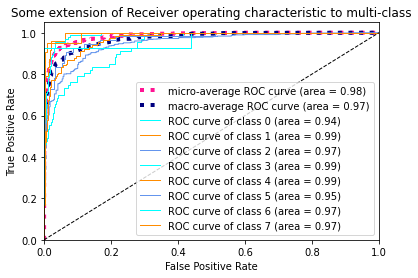

In [11]:
n_classes = 8
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
lw = 1
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()